In [103]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.lagrangian_datatools import *
import src.data.statistics as ds
import importlib
import seaborn as sns
import scienceplots

# styles for the report
plt.style.use(['science','nature'])
plt.rcParams.update({'figure.dpi': '200'}) 
# set the font size for the text of the plots
plt.rcParams.update({'font.size': 14, "legend.fontsize":"small", "lines.linewidth":.8}) 

In [112]:
importlib.reload(ds)

<module 'src.data.statistics' from '/home/maria/Documents/github/multiscale-turbulence/src/data/statistics.py'>

In [78]:
colors =['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

plot_kwargs = {"fillstyle": "none", "markersize": 2, "markevery": 2, "capsize": 1}


In [113]:
# comparing with the same number of points
N_GEN_DATA = 1000 
SEED = 42
# Parameters for error bars
SUBSAMPLING_TIMES = 10

# sampling from the original data
np.random.seed(SEED)

# Original data
orig_fname = "../data/velocities.npy"
orig_data = ParticleDataset(npy_filename=orig_fname, root_dir=".")

# subsample the original data to match in length to the generated data
idx = np.random.choice(len(orig_data), N_GEN_DATA, replace=False)
orig_stat = ds.StatisticalPhysics(orig_data[idx]) 

# Statistics of data generated with DiffWave

This set corresponds to a model trained for 450K steps, with a learning rate of 2e-04, and with normalization and scaling of input data to [-1,1].  
In the inference process, no clamping was performed, only the reverse normalization. Also, fast-sampling was not applied.    
**Experiment code**: 1259530  
**Model code**: weights-20230612-1259530.pt

In [11]:
# Loading the data
filename = "/home/maria/Documents/github/diffwave/output/experiment_1259530/generated_samples_1d.npy"
d1 = ParticleDataset(npy_filename=filename, root_dir=".")

Text(0.5, 0, 't')

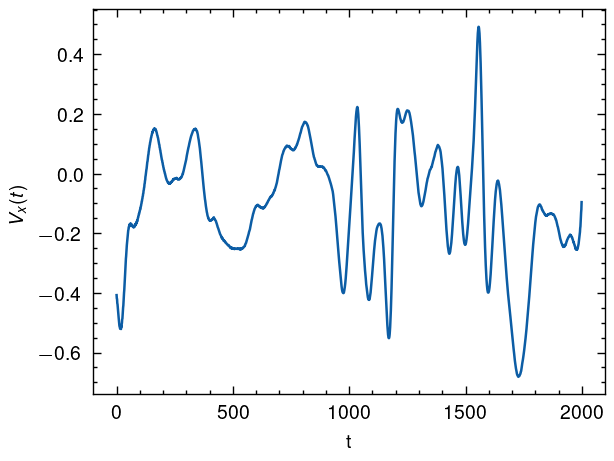

In [12]:
# one sample
sample_1 = d1[10]

plt.plot(np.arange(2000), sample_1[:,0])
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

In [114]:
stat = ds.StatisticalPhysics(d1)

In [33]:
# tau goes from 1 to 1000
list_taus = np.unique([int(t) for t in np.logspace(0, 3)]).astype(int)
list_n=[4, 6]

## Flatness

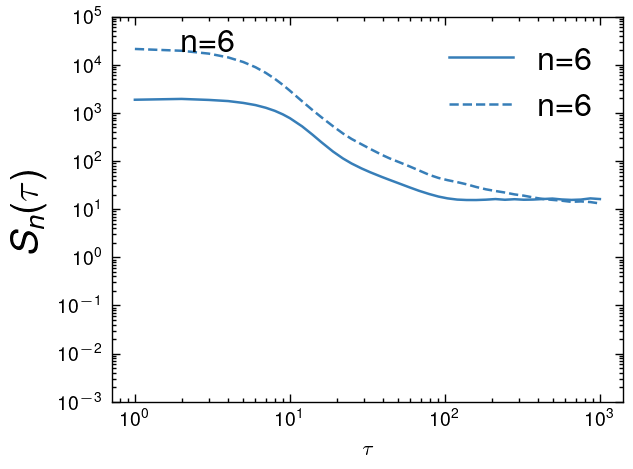

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim(bottom=10e-4, top=10e4)
ax.set_ylabel(r"$S_n({\tau})$", size=14)
ax.set_xlabel(r"$\tau$")
ax.set_yscale("log")
ax.set_xscale("log")

for i,n in enumerate(list_n):
    tau, sn_tau = stat.compute_flatness_function(n, coordinate=0)
    ax.plot(tau, sn_tau, label=r"n=" + str(n), color=colors[i])
    # Original data will have markers '+'
    tau, sn_tau = orig_stat.compute_flatness_function(n, coordinate=0)
    ax.plot(tau, sn_tau, label=r"n=" + str(n), color=colors[i], linestyle="--")
    ax.text(tau[1], sn_tau[1]+0.1, r"n=" + str(n), size="small")

plt.legend()
plt.show()

Confidence interval with subsampling method

In [34]:
subsamples = []
flatness_2 = {"values": [], "sd": None, "mean": None}
flatness_4 = {"values": [], "sd": None, "mean": None}
flatness_6 = {"values": [], "sd": None, "mean": None}

for _ in range(SUBSAMPLING_TIMES):
    subsample_idx = np.random.choice(len(d1), N_GEN_DATA, replace=True)
    subsample = d1[subsample_idx]
    subsamples.append(subsample)
    temp_stat = ds.StatisticalPhysics(subsample)
    for n in list_n:
        tau, fn_tau = temp_stat.compute_flatness_function(n, coordinate=0)
        if n == 2:
            flatness_2["values"].append(fn_tau)
        elif n == 4:
            flatness_4["values"].append(fn_tau)
        elif n == 6:
            flatness_6["values"].append(fn_tau)

# compute mean and standard error
# for each tau
# we can vertically stack the values and then compute the mean and std per column

flatness_4["values"] = np.vstack(flatness_4["values"])
flatness_4["ci"] = np.percentile(flatness_4["values"], [2.5, 97.5], axis=0)
flatness_4["mean"] = np.mean(flatness_4["values"], axis=0)
flatness_4["sd"] = np.std(flatness_4["values"], axis=0)

flatness_6["values"] = np.vstack(flatness_6["values"])
flatness_6["ci"] = np.percentile(flatness_6["values"], [2.5, 97.5], axis=0)
flatness_6["mean"] = np.mean(flatness_6["values"], axis=0)
flatness_6["sd"] = np.std(flatness_6["values"], axis=0)
flatness_6["se"] = flatness_6["sd"] / np.sqrt(flatness_6["values"].shape[0])

In [122]:
bootstrapped_stat = {2: flatness_2, 4: flatness_4, 6: flatness_6}
tau = np.unique([int(t) for t in np.logspace(0, 3)])

In [18]:
flatness_6["values"][0,1:5]

array([1883.61471981, 1787.33040495, 1685.71045559, 1532.84688791])

In [19]:
flatness_6["mean"][1:5]

array([2028.7336206 , 1936.99296699, 1838.28706274, 1687.47341881])

In [26]:
flatness_6["ci"]

array([[1001.81942979, 1032.05520897,  983.62848712,  934.0700265 ,
         862.29964791,  787.02168613,  704.27714263,  623.37823047,
         544.08204057,  463.36501546,  320.11524673,  225.72877603,
         166.1150115 ,  121.69425919,   97.55131591,   82.46967251,
          66.11270069,   55.53719339,   45.22852427,   39.46490065,
          33.34244306,   27.52990006,   22.95947796,   19.41293495,
          17.35534342,   16.15235758,   15.34297129,   14.91892518,
          14.87289362,   15.17201219,   15.39100878,   14.81211536,
          15.37296054,   15.16330866,   15.04361029,   14.64871579,
          15.17615319,   15.4593338 ,   15.4135574 ,   15.16178999,
          16.2274657 ,   15.5143355 ],
       [2901.78880075, 3125.72908932, 3005.54035753, 2869.69980774,
        2645.77858854, 2406.76967935, 2136.48531382, 1865.80014179,
        1595.27458856, 1338.77563483,  899.07475177,  587.26089355,
         384.04647496,  217.33242676,  140.15517263,  104.97795874,
         

In [32]:
flatness_6["se"]

array([1.91313363e+02, 2.10075878e+02, 2.02441805e+02, 1.92913333e+02,
       1.77176234e+02, 1.60359924e+02, 1.41553475e+02, 1.22907706e+02,
       1.04532905e+02, 8.73207603e+01, 5.79154825e+01, 3.68119251e+01,
       2.25973307e+01, 1.04199257e+01, 4.88489547e+00, 2.55545759e+00,
       1.37765681e+00, 9.06976428e-01, 5.64402242e-01, 4.12198677e-01,
       3.07289615e-01, 2.69763828e-01, 2.84864410e-01, 2.75226186e-01,
       1.98195164e-01, 1.19831683e-01, 7.32531863e-02, 1.04242791e-01,
       1.13426024e-01, 1.16353810e-01, 1.34933766e-01, 1.35692812e-01,
       1.20029260e-01, 1.14745888e-01, 1.63001067e-01, 2.37052590e-01,
       2.71397876e-01, 7.07799136e-02, 1.09530927e-01, 1.40889155e-01,
       1.46346918e-01, 1.46799946e-01])

error bars with 95% confidence interval

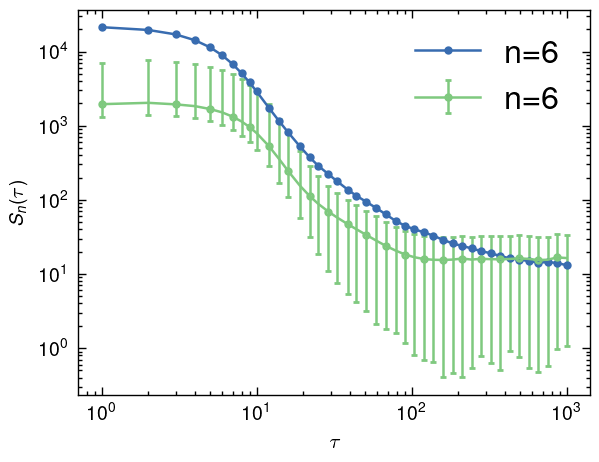

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel(r"$S_n({\tau})$")
ax.set_xlabel(r"$\tau$")
ax.set_yscale("log")
ax.set_xscale("log")

for i,n in enumerate(list_n):
    ax.errorbar(tau, bootstrapped_stat[n]["mean"], yerr=bootstrapped_stat[n]["ci"], label=r"n=" + str(n),marker=markers[i], color=colors[0], **plot_kwargs)
    # Original data will have markers '+'
    tau, sn_tau = orig_stat.compute_flatness_function(n, coordinate=0)
    ax.plot(tau, sn_tau, label=r"n=" + str(n), marker=markers[i], markersize=2, color=colors[1])

plt.legend()
plt.show()

error bars with standard error

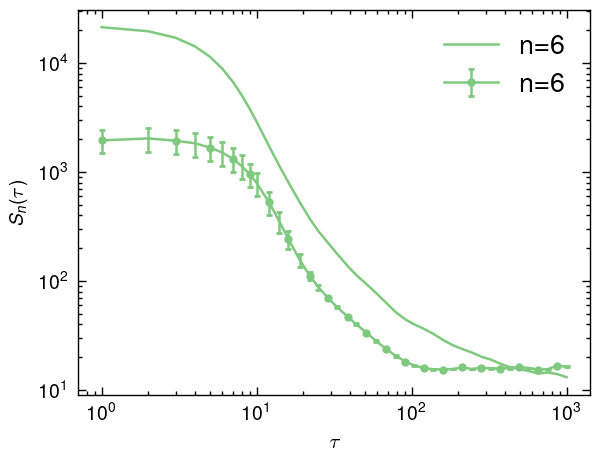

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel(r"$S_n({\tau})$")
ax.set_xlabel(r"$\tau$")
ax.set_yscale("log")
ax.set_xscale("log")

for i,n in enumerate(list_n):
    # plot error bar with markers with no filling
    ax.errorbar(tau, bootstrapped_stat[n]["mean"], yerr=bootstrapped_stat[n]["se"], label=r"n=" + str(n), color=colors[i], **plot_kwargs, )
    # Original data will have markers '+'
    tau, sn_tau = orig_stat.compute_flatness_function(n, coordinate=0)
    ax.plot(tau, sn_tau, label=r"n=" + str(n), color=colors[i])

plt.legend(fontsize="x-small")
plt.show()

and with standard deviation

In [127]:
# Try marker with no filling
plot_kwargs["marker"] = "o"
plot_kwargs["markersize"] = 3
plot_kwargs

{'fillstyle': 'none',
 'markersize': 3,
 'markevery': 2,
 'capsize': 1,
 'marker': 'o'}

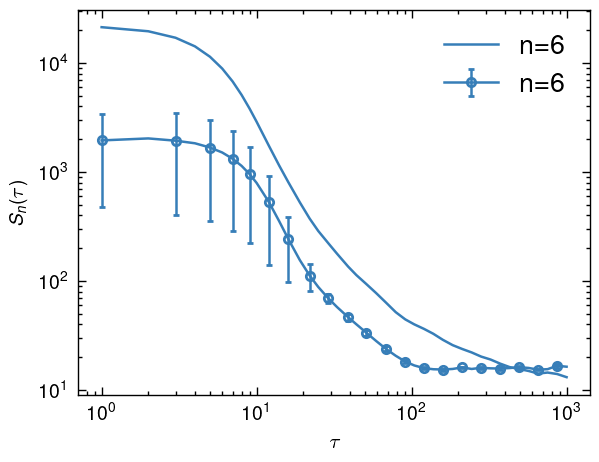

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel(r"$S_n({\tau})$")
ax.set_xlabel(r"$\tau$")
ax.set_yscale("log")
ax.set_xscale("log")

for i,n in enumerate(list_n):
    # plot error bar with markers with no filling
    ax.errorbar(tau, bootstrapped_stat[n]["mean"], yerr=bootstrapped_stat[n]["sd"], label=r"n=" + str(n), color=colors[i], errorevery=2, **plot_kwargs )
    # Original data will have markers '+'
    tau, sn_tau = orig_stat.compute_flatness_function(n, coordinate=0)
    ax.plot(tau, sn_tau, label=r"n=" + str(n), color=colors[i])

plt.legend(fontsize="x-small")
plt.show()

The std deviation is bigger than the SE. Setting the markers to be drawn every 2 points look good, not cluttered. I don't know how to set the filling to none, as the fillstyle argument doesn't work. **Update:** to get no filling, you have to set the global matplotlib property *"markers.fillstyle": "none"*.

## Structure functions

In [22]:
from matplotlib.lines import Line2D

Here I'll try to check what's a good approach to visualize curves and distinguish: levels, origin source. I'm going to use the same color for a given level, and a different line style for different origin source

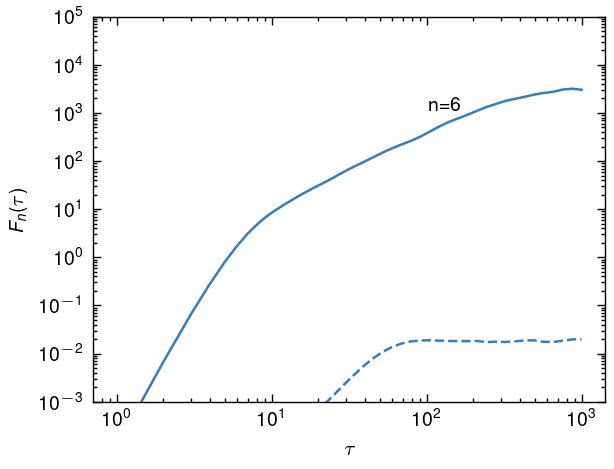

In [50]:
list_n=[6]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim(bottom=10e-4, top=10e4)
ax.set_ylabel(r"$F_n({\tau})$")
ax.set_xlabel(r"$\tau$")
ax.set_yscale("log")
ax.set_xscale("log")

lines = [Line2D([0], [0], linewidth=.9, linestyle='--', color='black'),
         Line2D([0], [0], linewidth=.9, linestyle='solid', color='black')]
labels = ['Generated', 'Original']


for i,n in enumerate(list_n):
    
    tau, fn_tau = stat.compute_lagrangian_structure_function(n, coordinate=0)
    ax.plot(tau, fn_tau, label=r"n=" + str(n), color=colors[i], linestyle="dashed")
    # Original data will have markers '+'
    tau, fn_tau = orig_stat.compute_lagrangian_structure_function(n, coordinate=0)
    ax.plot(tau, fn_tau, label=r"n=" + str(n), color=colors[i])
    ax.text(tau[25], fn_tau[30], r"n=" + str(n), size=7)

# set size for the legend
plt.legend(lines, labels, fontsize=7, loc="upper left")
plt.show()

Plot flatness again, using the new style, with std deviation as error bars

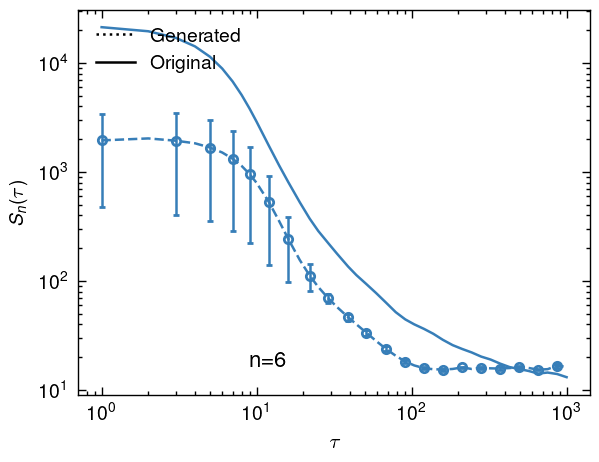

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel(r"$S_n({\tau})$")
ax.set_xlabel(r"$\tau$")
ax.set_yscale("log")
ax.set_xscale("log")


for i,n in enumerate(list_n):
    # plot error bar with markers with no filling
    ax.errorbar(tau, bootstrapped_stat[n]["mean"], yerr=bootstrapped_stat[n]["sd"], color=colors[i], errorevery=2, linestyle="dashed", **plot_kwargs )
    # Original data
    tau, sn_tau = orig_stat.compute_flatness_function(n, coordinate=0)
    ax.plot(tau, sn_tau, color=colors[i])
    ax.text(tau[8], fn_tau[11], r"n=" + str(n), size=8)

plt.legend(lines, labels, fontsize=7, loc="upper right")
plt.show()

The dashed line is less distinguishable. Let's try without a marker

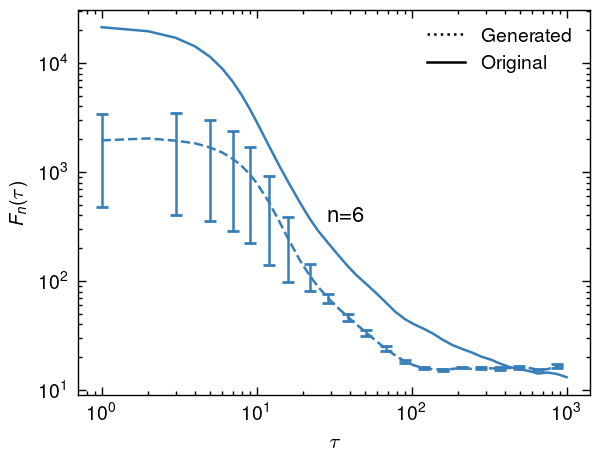

In [134]:
plot_kwargs_2 = {"capsize":2}
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel(r"$F_n({\tau})$")
ax.set_xlabel(r"$\tau$")
ax.set_yscale("log")
ax.set_xscale("log")


for i,n in enumerate(list_n):
    # plot error bar with markers with no filling
    ax.errorbar(tau, bootstrapped_stat[n]["mean"], yerr=bootstrapped_stat[n]["sd"], color=colors[i], errorevery=2, linestyle="dashed", **plot_kwargs_2 )
    # Original data
    tau, sn_tau = orig_stat.compute_flatness_function(n, coordinate=0)
    ax.plot(tau, sn_tau, color=colors[i])
    ax.text(tau[16], bootstrapped_stat[n]["mean"][11], r"n=" + str(n), size=8)

plt.legend(lines, labels, fontsize=7, loc="upper right")
plt.show()

looks better

## PDF's

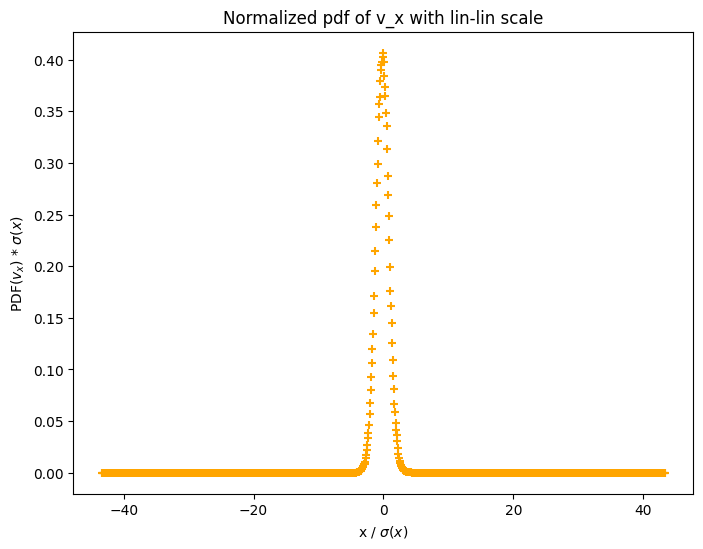

In [32]:
stat.plot_vx_norm_pdf(y_log=False)

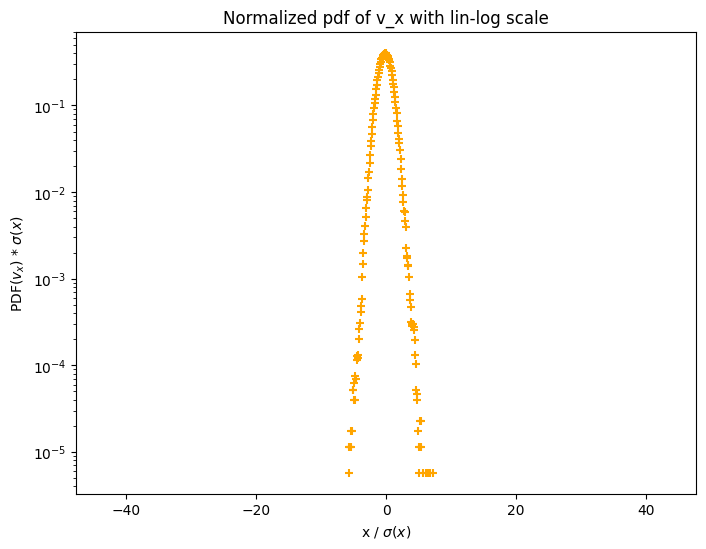

In [33]:
# In log scale
stat.plot_vx_norm_pdf(y_log=True)

In [72]:
# I'll try again to set no filling for the markers
plt.rcParams.update({"markers.fillstyle": "none", "lines.markersize": 2})

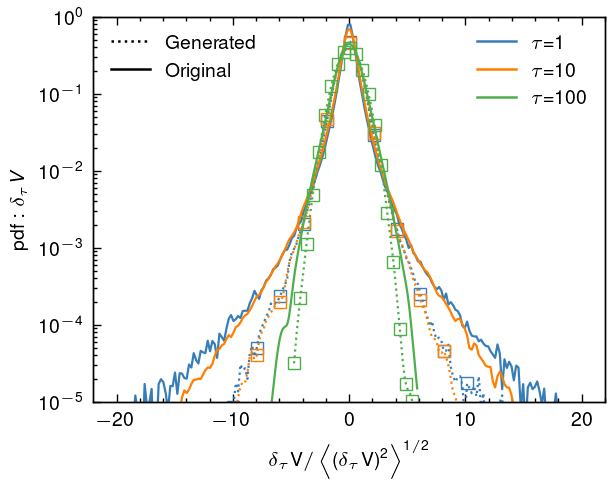

In [95]:
# pdf legacy plot method improved
_, ax = plt.subplots()
ax.set_ylim(bottom=10e-6, top=1)

ax.set_ylabel("pdf : " + r"$\delta_{\tau}V$")
ax.set_xlabel(
    r"$\delta_{\tau} \mathrm{V} /\left\langle\left(\delta_{\tau} \mathrm{V}\right)^{2}\right\rangle^{1 / 2}$")
test_taus = [1,10,100]
for i, tau in enumerate(test_taus):
    # plot original data pdfs
    norm_delta_tau_velocity = orig_stat.compute_delta_tau_velocity_for_pdf(tau, coordinate=0).flatten()
    sns.kdeplot(
        data=norm_delta_tau_velocity,
        label=r"$\tau$=" + str(tau),
        log_scale=(False, True),
        ax=ax,
        cut=0,
        clip=(-20, 20),
        bw_adjust=1+i*2,
        linewidth=.8,
        color=colors[i],
    )
     # plot generated data pdfs
    norm_delta_tau_velocity = stat.compute_delta_tau_velocity_for_pdf(tau, coordinate=0).flatten()
    sns.kdeplot(
        data=norm_delta_tau_velocity,
        label=r"$\tau$=" + str(tau),
        log_scale=(False, True),
        ax=ax,
        cut=0,
        clip=(-20, 20),
        bw_adjust=1+i*2,
        linestyle="dotted",
        marker="s",
        linewidth=.8,
        markevery=10,
        markersize=4,
        markeredgewidth=0.5, color=colors[i],
    )

# hack for showing the color legend
ax2 = ax.twinx()
for i, tau in enumerate(test_taus):
    ax2.plot(np.NaN, np.NaN, color=colors[i],
             label=r"$\tau$=" + str(tau))
ax2.get_yaxis().set_visible(False)

lines = [Line2D([0], [0], linewidth=.9, linestyle='dotted', color='black'),
         Line2D([0], [0], linewidth=.9, linestyle='solid', color='black')]

ax.legend(lines, labels, fontsize=7, loc="upper left") #legend for lines styles
ax2.legend(loc=1, fontsize=7) 
# save figure of only ax=ax
#extent = ax.get_window_extent().transformed(_.dpi_scale_trans.inverted())
#_.savefig('ax2_figure.eps', bbox_inches=extent, dpi=200)
plt.savefig("pdfs.eps", bbox_inches="tight", dpi=200)
plt.show()


PDF of acceleration

In [109]:
plt.rcParams.update({"lines.linewidth": .9})

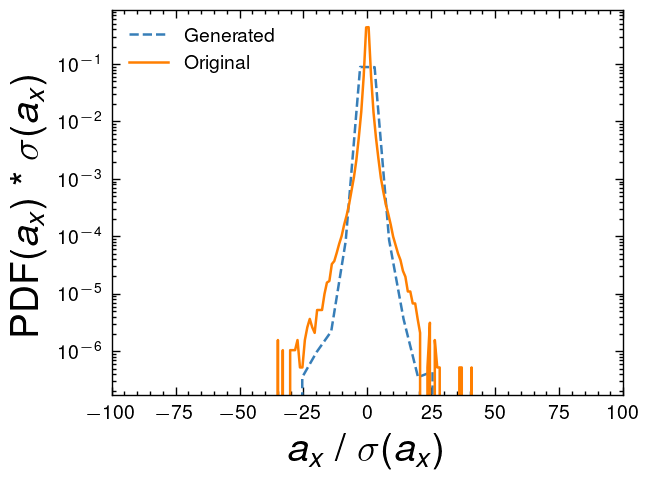

In [117]:
#In log scale
fig = plt.figure()
ax = fig.add_subplot(111)

stat.plot_ax_norm_pdf(y_log=True, ax=ax, label="Generated", linestyle="dashed", color=colors[0])
orig_stat.plot_ax_norm_pdf(y_log=True, ax=ax, label="Original", linestyle="solid", color=colors[1])

# set font size for the x and y labels
ax.yaxis.get_label().set_fontsize(14)
ax.xaxis.get_label().set_fontsize(14)
ax.set_title("")

plt.legend(loc="upper left", fontsize=7)